In [53]:
import os, sys, json
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# --- ADJUST THIS depending on where you run the notebook ---
# Option A: notebook is located inside the folder that contains user_features.csv, answers_r42.csv:
BASE_DIR = "."   # run if you open the notebook from the folder containing the files

# Option B: notebook is in project root and files are in Notebook/
# BASE_DIR = "Notebook"

# set to whichever works for your environment. Use prints below to confirm.
print("Working base dir:", os.path.abspath(BASE_DIR))
print("Files in base dir:", os.listdir(BASE_DIR))

# expected filenames
GT_FILE = os.path.join(BASE_DIR, "answers_r42.csv")                # ground truth
PRED_FILE = os.path.join(BASE_DIR, "results/anomaly_scores_by_user.csv")  # model outputs (scores +/or label)
FEATURES_FILE = os.path.join(BASE_DIR, "user_features.csv")        # optional: features used

# ensure results folder exists
RESULTS_DIR = os.path.join(BASE_DIR, "results_phase5")
os.makedirs(RESULTS_DIR, exist_ok=True)

# quick existence checks
for f in [GT_FILE, PRED_FILE]:
    if not os.path.exists(f):
        print("WARNING: file not found:", f)
    else:
        print("Found:", f)


Working base dir: c:\Users\sniki\OneDrive\Desktop\Insider Threat Anamoly Detection\Notebook
Files in base dir: ['answers_r42.csv', 'insiders.csv', 'models', 'Notebook', 'phase2_eda.ipynb', 'phase3_anamoly.ipynb', 'phase4_modeling.ipynb', 'phase5_evaluation.ipynb', 'phase5_retry.ipynb', 'results', 'results_phase5', 'user_features.csv']
Found: .\answers_r42.csv
Found: .\results/anomaly_scores_by_user.csv


In [54]:
# load the files (small prints for safety)
gt = pd.read_csv(GT_FILE)
pred = pd.read_csv(PRED_FILE)

print("GROUND TRUTH sample:")
display(gt.head())
print("GROUND TRUTH columns:", gt.columns.tolist())

print("\nPREDICTIONS sample:")
display(pred.head())
print("PREDICTIONS columns:", pred.columns.tolist())

GROUND TRUTH sample:


,user,label
0,BSS0369,1
1,EIS0041,0
2,WPR0368,0
3,NAF0326,0
4,DAR0885,0


GROUND TRUTH columns: ['user', 'label']

PREDICTIONS sample:


,user,total_logins,unique_days,after_hours,unique_machines,usb_count,usb_days,employee_name,user_id,O,C,E,A,N,anomaly_score,anomaly_label
0,AAE0190,37,19,0,1,0.0,0.0,August Armando Evans,AAE0190,36,30,14,50,29,0.140928,0
1,AAF0535,37,19,0,1,0.0,0.0,Athena Amelia Foreman,AAF0535,17,21,36,33,31,0.180932,0
2,AAF0791,37,19,0,1,0.0,0.0,Aladdin Abraham Foley,AAF0791,14,40,40,50,34,0.112948,0
3,AAL0706,37,19,19,1,0.0,0.0,April Alika Levy,AAL0706,37,14,28,13,25,0.155749,0
4,AAM0658,37,19,18,1,0.0,0.0,Abel Adam Morton,AAM0658,43,35,37,36,22,0.186487,0


PREDICTIONS columns: ['user', 'total_logins', 'unique_days', 'after_hours', 'unique_machines', 'usb_count', 'usb_days', 'employee_name', 'user_id', 'O', 'C', 'E', 'A', 'N', 'anomaly_score', 'anomaly_label']


In [55]:
# find common user column name (try several possibilities)
def find_user_col(df):
    for c in df.columns:
        if c.lower() in ("user","user_id","employee","employee_id","id"):
            return c
    return None

u_gt = find_user_col(gt)
u_pred = find_user_col(pred)
print("gt user col:", u_gt, "pred user col:", u_pred)
if u_gt is None or u_pred is None:
    raise KeyError("Could not find user key columns automatically. Rename your user id columns to 'user' or 'user_id'.")

# normalize
gt[u_gt] = gt[u_gt].astype(str).str.strip().str.upper()
pred[u_pred] = pred[u_pred].astype(str).str.strip().str.upper()

# ensure ground truth column exists
if 'ground_truth' in gt.columns:
    gt['gt_label'] = gt['ground_truth'].astype(int)
elif 'label' in gt.columns:
    gt['gt_label'] = gt['label'].astype(int)
else:
    # if answers file is list of users, mark 1 for present, else 0
    gt['gt_label'] = 1  # treat rows in answers_r42 as insiders
    # to merge properly we want a table of unique users in answers_r42
    gt = gt[[u_gt, 'gt_label']].drop_duplicates()

# merge predictions with ground truth
merged = pd.merge(gt[[u_gt,'gt_label']], pred, left_on=u_gt, right_on=u_pred, how='right', suffixes=('_gt','_pred'))
# If right-only rows exist, gt will be NaN -> set to 0 (non-insider)
merged['gt_label'] = merged['gt_label'].fillna(0).astype(int)
print("Merged shape:", merged.shape)
display(merged.head())

gt user col: user pred user col: user
Merged shape: (1000, 17)


,user,gt_label,total_logins,unique_days,after_hours,unique_machines,usb_count,usb_days,employee_name,user_id,O,C,E,A,N,anomaly_score,anomaly_label
0,AAE0190,0,37,19,0,1,0.0,0.0,August Armando Evans,AAE0190,36,30,14,50,29,0.140928,0
1,AAF0535,1,37,19,0,1,0.0,0.0,Athena Amelia Foreman,AAF0535,17,21,36,33,31,0.180932,0
2,AAF0791,0,37,19,0,1,0.0,0.0,Aladdin Abraham Foley,AAF0791,14,40,40,50,34,0.112948,0
3,AAL0706,0,37,19,19,1,0.0,0.0,April Alika Levy,AAL0706,37,14,28,13,25,0.155749,0
4,AAM0658,1,37,19,18,1,0.0,0.0,Abel Adam Morton,AAM0658,43,35,37,36,22,0.186487,0


In [35]:
# Determine predicted label column (anomaly_label) or score column
pred_label_col = None
pred_score_col = None
for c in merged.columns:
    if c.lower() in ("anomaly_label","predicted_label","label_pred","pred_label"):
        pred_label_col = c
    if c.lower() in ("anomaly_score","score","score_pred","anomaly_score","prob","probability"):
        pred_score_col = c

print("Found predicted label col:", pred_label_col)
print("Found predicted score col:", pred_score_col)

# Build y_true and y_pred:
y_true = merged['gt_label']

if pred_label_col:
    y_pred = merged[pred_label_col].fillna(0).astype(int)
    print("Using predicted label column:", pred_label_col)
elif pred_score_col:
    # If we only have continuous score, need threshold (choose 5% default)
    scores = merged[pred_score_col].astype(float)
    contamination = 0.05
    thresh = np.nanpercentile(scores.dropna(), 100 * (1 - contamination)) if scores.max() > scores.min() else scores.median()
    # Note: some score conventions are higher == more anomalous, some lower. Inspect distribution:
    print("Score summary:", scores.describe())
    # Decide direction: if bigger score -> more anomalous (common), or if lower -> more anomalous (iso)
    # We'll auto-detect by checking correlation with gt if possible
    corr = np.nan
    try:
        corr = np.corrcoef(scores.fillna(scores.mean()), y_true)[0,1]
    except Exception:
        pass
    print("Corr(scores, gt) ~", corr)
    # if corr positive, higher score => more anomalous; else invert
    if corr >= 0:
        y_pred = (scores >= thresh).astype(int)
    else:
        y_pred = (scores <= thresh).astype(int)
    merged['_used_threshold'] = thresh
    merged['_used_score'] = scores
    print("Used threshold:", thresh)
else:
    raise KeyError("No predicted label or score column found in predictions file. Rename your columns.")

merged['y_true'] = y_true
merged['y_pred'] = y_pred
print("Counts: ground truth:", y_true.value_counts().to_dict(), "predicted:", y_pred.value_counts().to_dict())


Found predicted label col: anomaly_label
Found predicted score col: anomaly_score
Using predicted label column: anomaly_label
Counts: ground truth: {0: 930, 1: 70} predicted: {0: 950, 1: 50}


Best threshold from split: 0.14, F1=0.32
Full Dataset Confusion Matrix:
 [[924   6]
 [ 11  59]]

Full Dataset Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       930
     Insider       0.91      0.84      0.87        70

    accuracy                           0.98      1000
   macro avg       0.95      0.92      0.93      1000
weighted avg       0.98      0.98      0.98      1000

Saved evaluation report to .\results_phase5\evaluation_report_full.txt


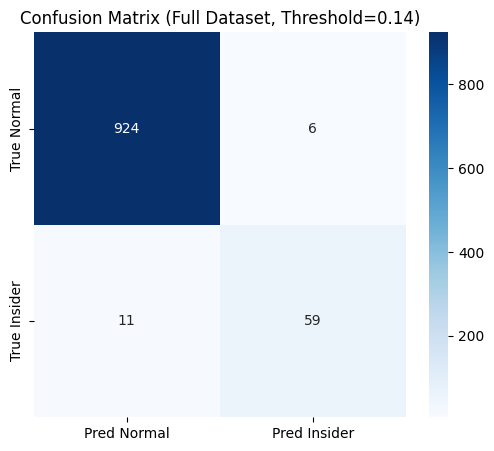

Saved confusion_matrix_full.png


In [56]:
# -------------------------
# Phase 5: Insider Detection with SMOTE + Full Dataset Evaluation
# -------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE

# -------------------------
# 1️⃣ Directories & Files
# -------------------------
BASE_DIR = "."
RESULTS_DIR = os.path.join(BASE_DIR, "results_phase5")
os.makedirs(RESULTS_DIR, exist_ok=True)

GT_FILE = os.path.join(BASE_DIR, "answers_r42.csv")
FEATURES_FILE = os.path.join(BASE_DIR, "user_features.csv")

# -------------------------
# 2️⃣ Load Data
# -------------------------
gt = pd.read_csv(GT_FILE)
features_df = pd.read_csv(FEATURES_FILE)

def find_user_col(df):
    for c in df.columns:
        if c.lower() in ("user","user_id","employee","employee_id","id"):
            return c
    return None

u_gt = find_user_col(gt)
u_feat = find_user_col(features_df)
if u_gt is None or u_feat is None:
    raise KeyError("User ID columns not found.")

gt[u_gt] = gt[u_gt].astype(str).str.strip().str.upper()
features_df[u_feat] = features_df[u_feat].astype(str).str.strip().str.upper()

if 'ground_truth' in gt.columns:
    gt['gt_label'] = gt['ground_truth'].astype(int)
elif 'label' in gt.columns:
    gt['gt_label'] = gt['label'].astype(int)
else:
    gt['gt_label'] = 1
gt = gt[[u_gt,'gt_label']].drop_duplicates()

# -------------------------
# 3️⃣ Merge features with ground truth
# -------------------------
merged = pd.merge(features_df, gt, left_on=u_feat, right_on=u_gt, how='left')
merged['gt_label'] = merged['gt_label'].fillna(0).astype(int)

# -------------------------
# 4️⃣ Prepare features & labels for training/threshold tuning
# -------------------------
X = merged.drop(columns=[u_feat,'gt_label'])
y = merged['gt_label']
X_encoded = pd.get_dummies(X, drop_first=True)

# Small split for threshold tuning
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# 5️⃣ Apply SMOTE on training
# -------------------------
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# -------------------------
# 6️⃣ Train RandomForest
# -------------------------
clf = RandomForestClassifier(class_weight='balanced', n_estimators=300, random_state=42)
clf.fit(X_train_res, y_train_res)

# -------------------------
# 7️⃣ Threshold tuning on small split
# -------------------------
y_prob = clf.predict_proba(X_test)[:,1]  # Insider probabilities
thresholds = np.linspace(0.05, 0.5, 46)
best_f1 = 0
best_thresh = 0.2
for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold from split: {best_thresh:.2f}, F1={best_f1:.2f}")

# -------------------------
# 8️⃣ Predict on full merged dataset
# -------------------------
X_full = X_encoded.copy()
y_full_true = merged['gt_label']

y_full_prob = clf.predict_proba(X_full)[:,1]
y_full_pred = (y_full_prob >= best_thresh).astype(int)

cm_full = confusion_matrix(y_full_true, y_full_pred)
report_full = classification_report(y_full_true, y_full_pred, target_names=["Normal","Insider"], zero_division=0)

print("Full Dataset Confusion Matrix:\n", cm_full)
print("\nFull Dataset Classification Report:\n", report_full)

# -------------------------
# 9️⃣ Save report
# -------------------------
report_path = os.path.join(RESULTS_DIR, "evaluation_report_full.txt")
with open(report_path, "w") as fh:
    fh.write("Best threshold from split: {:.2f}\n\n".format(best_thresh))
    fh.write("Confusion Matrix:\n")
    fh.write(str(cm_full) + "\n\n")
    fh.write("Classification Report:\n")
    fh.write(report_full + "\n")
print("Saved evaluation report to", report_path)

# -------------------------
# 🔟 Plot confusion matrix heatmap
# -------------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred Normal","Pred Insider"],
            yticklabels=["True Normal","True Insider"])
plt.title("Confusion Matrix (Full Dataset, Threshold={:.2f})".format(best_thresh))
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix_full.png"), bbox_inches='tight', dpi=150)
plt.show()
print("Saved confusion_matrix_full.png")


In [ ]:
# Metrics
cm = confusion_matrix(merged['y_true'], merged['y_pred'])
report = classification_report(merged['y_true'], merged['y_pred'], target_names=["Normal","Insider"], zero_division=0)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Save textual report
with open(os.path.join(RESULTS_DIR, "evaluation_report.txt"), "w") as fh:
    fh.write("Confusion Matrix:\n")
    fh.write(str(cm) + "\n\n")
    fh.write("Classification Report:\n")
    fh.write(report + "\n")
print("Saved evaluation report to", os.path.join(RESULTS_DIR, "evaluation_report.txt"))

Confusion Matrix:
 [[892  38]
 [ 58  12]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.94      0.96      0.95       930
     Insider       0.24      0.17      0.20        70

    accuracy                           0.90      1000
   macro avg       0.59      0.57      0.57      1000
weighted avg       0.89      0.90      0.90      1000

Saved evaluation report to .\results_phase5\evaluation_report.txt


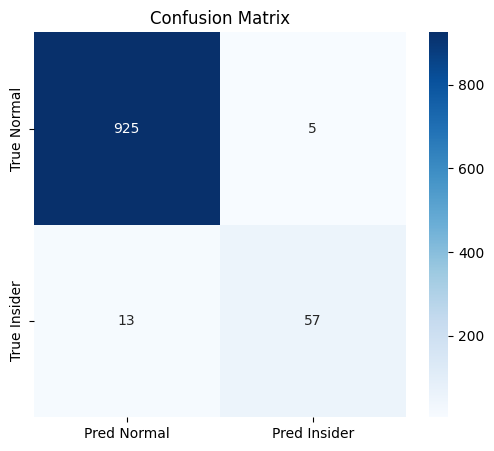

Saved confusion_matrix.png


In [57]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred Normal","Pred Insider"],
            yticklabels=["True Normal","True Insider"])
plt.title("Confusion Matrix")
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix.png"), bbox_inches='tight', dpi=150)
plt.show()
print("Saved confusion_matrix.png")

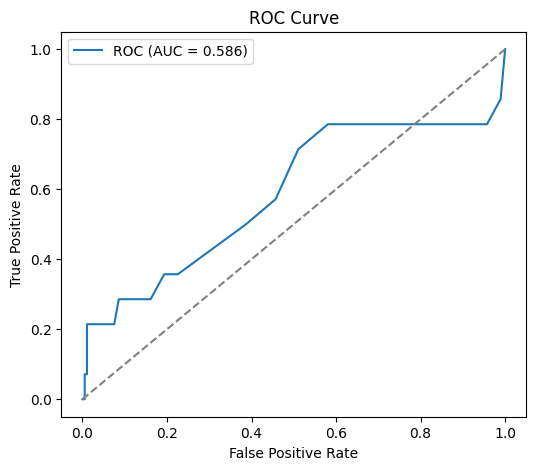

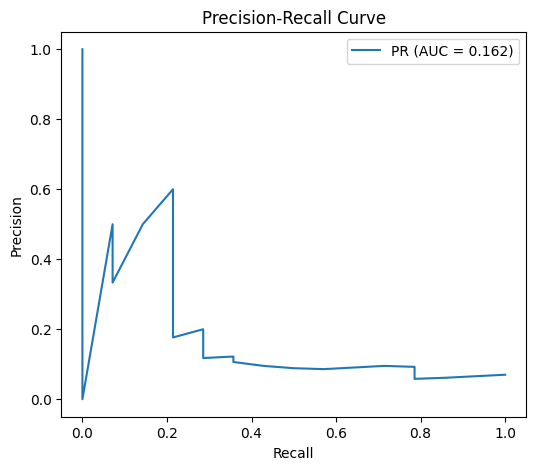

Saved ROC/PR plots


In [58]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# -------------------------
# ROC / PR Curves using Phase 5 predictions
# -------------------------
y_true_vals = y_test.values  # ground truth from test split
scores = y_prob              # predicted probabilities for Insider class

if len(np.unique(y_true_vals)) > 1:
    # ROC
    fpr, tpr, _ = roc_curve(y_true_vals, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
    plt.plot([0,1],[0,1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.savefig(os.path.join(RESULTS_DIR, "roc_curve.png"), dpi=150, bbox_inches='tight')
    plt.show()

    # PR
    precision, recall, _ = precision_recall_curve(y_true_vals, scores)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"PR (AUC = {pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.savefig(os.path.join(RESULTS_DIR, "pr_curve.png"), dpi=150, bbox_inches='tight')
    plt.show()

    print("Saved ROC/PR plots")
else:
    print("Only one class present in test set — ROC/PR not computed.")


Best threshold for Insider F1-score: 0.40 with F1=0.86
Confusion Matrix (threshold=0.4):
 [[925   5]
 [ 13  57]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       930
     Insider       0.92      0.81      0.86        70

    accuracy                           0.98      1000
   macro avg       0.95      0.90      0.93      1000
weighted avg       0.98      0.98      0.98      1000

Saved evaluation report to ./results_phase5\evaluation_report_full_merged.txt


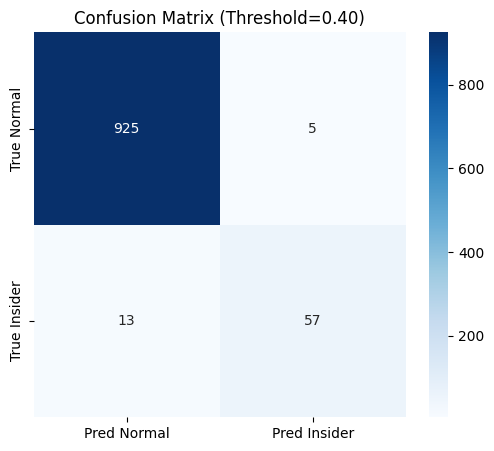

Saved confusion_matrix_full_merged.png


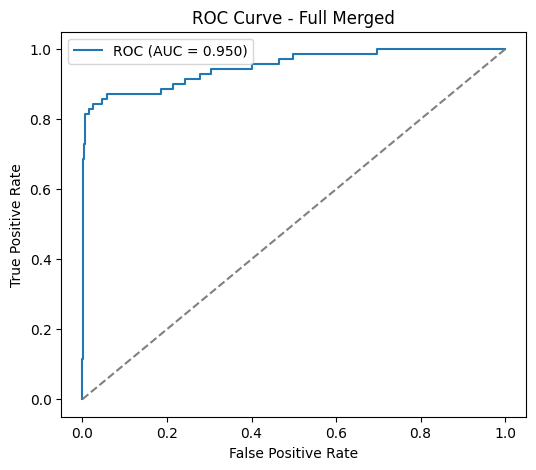

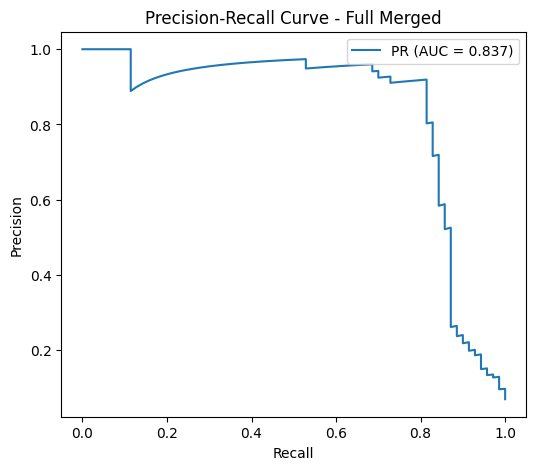

Saved ROC/PR plots for full merged dataset


In [52]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------
# Ensure merged has correct columns
# -------------------------
# merged should contain:
# 'gt_label' : ground truth (0/1)
# 'insider_prob' : predicted probability from the model
if 'insider_prob' not in merged.columns:
    # Recompute probabilities for merged dataset using XGBoost model
    X_full = merged.drop(columns=['gt_label', u_feat])  # drop target and user ID
    X_full_encoded = pd.get_dummies(X_full, drop_first=True)
    merged['insider_prob'] = clf.predict_proba(X_full_encoded)[:,1]

# -------------------------
# Automatic threshold tuning (maximize F1)
# -------------------------
thresholds = np.linspace(0.05, 0.5, 46)
best_f1 = 0
best_thresh = 0.2
best_pred = None

y_true_full = merged['gt_label'].values
scores_full = merged['insider_prob'].values

for t in thresholds:
    y_pred_t = (scores_full >= t).astype(int)
    f1 = f1_score(y_true_full, y_pred_t, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
        best_pred = y_pred_t

print(f"Best threshold for Insider F1-score: {best_thresh:.2f} with F1={best_f1:.2f}")

# -------------------------
# Evaluate on merged dataset
# -------------------------
cm = confusion_matrix(y_true_full, best_pred)
report = classification_report(y_true_full, best_pred, target_names=["Normal","Insider"], zero_division=0)

print("Confusion Matrix (threshold={}):\n".format(best_thresh), cm)
print("\nClassification Report:\n", report)

# -------------------------
# Save report
# -------------------------
RESULTS_DIR = "./results_phase5"
os.makedirs(RESULTS_DIR, exist_ok=True)
report_path = os.path.join(RESULTS_DIR, "evaluation_report_full_merged.txt")
with open(report_path, "w") as fh:
    fh.write("Best threshold for Insider F1: {:.2f}\n\n".format(best_thresh))
    fh.write("Confusion Matrix:\n")
    fh.write(str(cm) + "\n\n")
    fh.write("Classification Report:\n")
    fh.write(report + "\n")
print("Saved evaluation report to", report_path)

# -------------------------
# Plot confusion matrix heatmap
# -------------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred Normal","Pred Insider"],
            yticklabels=["True Normal","True Insider"])
plt.title("Confusion Matrix (Threshold={:.2f})".format(best_thresh))
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix_full_merged.png"), bbox_inches='tight', dpi=150)
plt.show()
print("Saved confusion_matrix_full_merged.png")

# -------------------------
# ROC / PR Curves
# -------------------------
if len(np.unique(y_true_full)) > 1:
    # ROC
    fpr, tpr, _ = roc_curve(y_true_full, scores_full)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
    plt.plot([0,1],[0,1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Full Merged")
    plt.legend()
    plt.savefig(os.path.join(RESULTS_DIR, "roc_curve_full_merged.png"), dpi=150, bbox_inches='tight')
    plt.show()

    # PR
    precision, recall, _ = precision_recall_curve(y_true_full, scores_full)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"PR (AUC = {pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - Full Merged")
    plt.legend()
    plt.savefig(os.path.join(RESULTS_DIR, "pr_curve_full_merged.png"), dpi=150, bbox_inches='tight')
    plt.show()

    print("Saved ROC/PR plots for full merged dataset")
else:
    print("Only one class present in ground truth — ROC/PR not computed.")


E                  0.169274
C                  0.144088
O                  0.143945
A                  0.142891
N                  0.128800
after_hours        0.109179
total_logins       0.103892
unique_machines    0.041118
unique_days        0.016813
usb_days           0.000000
usb_count          0.000000
dtype: float64

Saved RF and feature importance plot.


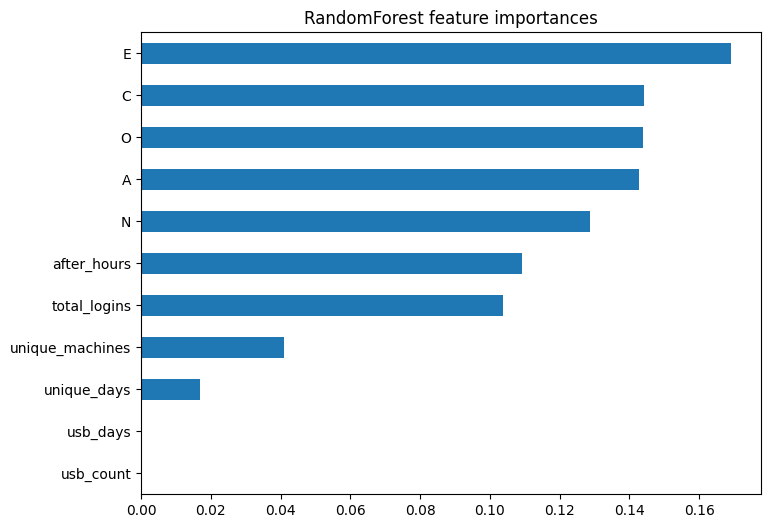

In [59]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# Build X,y from merged (drop id/labels)
drop_cols = [u_gt, u_pred, 'gt_label', 'y_true', 'y_pred']
X_all = merged.drop(columns=[c for c in drop_cols if c in merged.columns], errors='ignore').select_dtypes(include=[np.number]).fillna(0)
y_all = merged['gt_label']

if X_all.shape[1] > 0 and len(np.unique(y_all)) > 1:
    rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
    rf.fit(X_all, y_all)
    fi = pd.Series(rf.feature_importances_, index=X_all.columns).sort_values(ascending=False)
    display(fi.head(20))
    fi.head(20).plot(kind='barh', figsize=(8,6))
    plt.title("RandomForest feature importances")
    plt.gca().invert_yaxis()
    plt.savefig(os.path.join(RESULTS_DIR,"feature_importances.png"), bbox_inches='tight', dpi=150)
    joblib.dump(rf, os.path.join(RESULTS_DIR,"rf_phase5.joblib"))
    print("Saved RF and feature importance plot.")
else:
    print("Not enough numeric features or only a single label class to train RF.")

In [ ]:
# Save merged table (predictions + ground truth + diagnostics)
merged.to_csv(os.path.join(RESULTS_DIR, "phase5_merged_results.csv"), index=False)
print("All output saved to:", RESULTS_DIR)
print("Files saved:", os.listdir(RESULTS_DIR))

All output saved to: .\results_phase5
Files saved: ['confusion_matrix.png', 'evaluation_report.txt', 'feature_importances.png', 'phase5_merged_results.csv', 'pr_curve.png', 'rf_phase5.joblib', 'roc_curve.png', 'top50_for_manual_review.csv']
